In [56]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras.backend as k
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
BATCH_SIZE = 64  
EPOCHS = 100  
LATENT_DIM = 256  
NUM_SAMPLES = 30000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [4]:
input_texts = [] 
target_texts = [] 
target_texts_inputs = []

In [5]:
t = 0
for line in open('ita-eng/ita.txt',encoding='utf-8'):
    t += 1
    if t > NUM_SAMPLES:
        break

    if '\t' not in line:
        continue

    input_text, translation = line.rstrip().split('\t')

    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 30000


In [6]:
#### input- English
#### output- Italian

In [7]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [8]:
word2idx_inputs = tokenizer_inputs.word_index
print('{} unique input tokens.'.format(len(word2idx_inputs)))

3113 unique input tokens.


In [9]:
max_len_input = max(len(s) for s in input_sequences)

In [10]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) 
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 9727 unique output tokens.


In [11]:
num_words_output = len(word2idx_outputs) + 1    ####because the encoding starts from 1
max_len_target = max(len(s) for s in target_sequences)

In [12]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (30000, 5)
encoder_inputs[0]: [   0    0    0    0 1382]


In [13]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_inputs[0]: [   2 1839    0    0    0    0    0    0    0]
decoder_inputs.shape: (30000, 9)


In [14]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

# Loading pretrained word embeddings

In [15]:
word2vec = {}
with open('glove.6B/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('found {} words in embedding'.format(len(word2vec)))

found 400000 words in embedding



# Using pretrained embeddings

In [16]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
    if embedding_vector is not None:                                                        
        embedding_matrix[i] = embedding_vector  # words not found in embedding index will be all zeros.

In [17]:
embedding_layer = Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_len_input,)

W0811 05:23:36.625159  1412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [18]:
decoder_targets_one_hot = np.zeros((len(input_texts),max_len_target,num_words_output)) ####for using categorical crossentropy

In [19]:
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [20]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True,)
encoder_outputs, h, c = encoder(x)

W0811 05:23:42.364829  1412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 05:23:42.366793  1412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 05:23:42.373370  1412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0811 05:23:42.374368  1412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [21]:
encoder_states = [h, c]

In [22]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [23]:
decoder_lstm = LSTM(LATENT_DIM,  return_sequences=True,  return_state=True,)
decoder_outputs, h, c = decoder_lstm(decoder_inputs_x,  initial_state=encoder_states)

In [24]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [25]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [26]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

W0811 05:23:46.786103  1412 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 100)       311400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         multiple             2490368     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [27]:
r = model.fit([encoder_inputs, decoder_inputs], decoder_targets_one_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2,)

W0811 05:23:47.537619  1412 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 24000 samples, validate on 6000 samples
Epoch 1/100
24000/24000 [==============================] - 236s 10ms/step - loss: 2.1702 - acc: 0.6995 - val_loss: 2.1936 - val_acc: 0.6934
Epoch 2/100
24000/24000 [==============================] - 212s 9ms/step - loss: 1.5627 - acc: 0.7611 - val_loss: 1.9594 - val_acc: 0.7282
Epoch 3/100
24000/24000 [==============================] - 204s 9ms/step - loss: 1.3325 - acc: 0.7866 - val_loss: 1.8235 - val_acc: 0.7440
Epoch 4/100
24000/24000 [==============================] - 216s 9ms/step - loss: 1.1795 - acc: 0.8032 - val_loss: 1.7464 - val_acc: 0.7512
Epoch 5/100
24000/24000 [==============================] - 231s 10ms/step - loss: 1.0621 - acc: 0.8174 - val_loss: 1.7174 - val_acc: 0.7557
Epoch 6/100
24000/24000 [==============================] - 224s 9ms/step - loss: 0.9724 - acc: 0.8286 - val_loss: 1.6839 - val_acc: 0.7606
Epoch 7/100
24000/24000 [==============================] - 223s 9ms/step - loss: 0.9008 - acc: 0.8379 - val_loss: 1

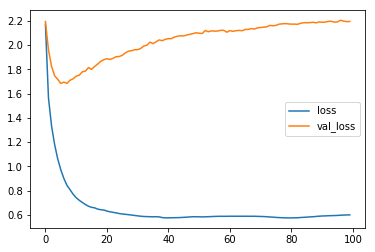

In [37]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

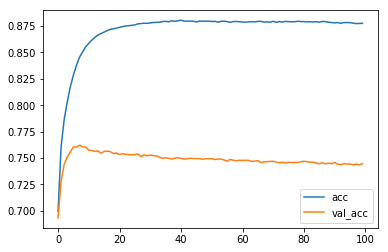

In [38]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [39]:
model.save('encoder_decoder.h5')

# Now building a model for Prediction

In [40]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [41]:
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [42]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x,initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [43]:
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [44]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

# fucntion to translate the sentence

In [45]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [53]:
while True:
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', input_texts[i])
    print('Translation:', translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

-
Input: I won't lie.
Translation: io non sono non la sono lei sono lei
Continue? [Y/n]y
-
Input: You've changed.
Translation: è cambiato.
Continue? [Y/n]y
-
Input: Tom biked home.
Translation: tom è andato a casa in bici.
Continue? [Y/n]n
